## GFAST Tutorial ##
This notebook will walk through a basic example using GFAST. 

We will first create an example signal for purposes of the tutorial. Then, we will use GFAST to recover the Fourier coefficients. Running GFast can be broken down into three steps:
1. Querying GFast for datapoints to sample 
2. Computing the samples
3. Running GFast

In [1]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from gfast.utils import get_banned_indices_from_qs, load_data, save_data
from synt_exp.synt_src.synthetic_signal import get_random_signal
from pathlib import Path
from gfast.commands import *
np.random.seed(42)

# 0. Generating an example signal
For this tutorial, we will generate a simple signal to run GFast on. Here, we've specified the following parameters:
- `qs`: the alphabet size at each position ($\mathbf{q} = [4, 4, 3, 3, 3, 4]$)
- `n = 6`: the total number of positions in the signal
- `sparsity = 9`: the number of non-zero Fourier coefficients ($S=9$)

The variable `banned_indices` is used to specify the alphabets at each site of the signal that are not present compared to the maximum alphabet size in `qs`. This is mostly useful in real-world experiments where the alphabets correspond to some real input (e.g. an amino acid sequence). Note that `noise_sd` is used here to generate the signal. In a real world experiment, the only use of `noise_sd` is to determine the cutoff for the energy of each subsampled Fourier transform, and can be treated as a hyperparameter.

In [3]:
qs = np.array([4, 4, 3, 3, 3, 4])
q = np.max(qs)
n = len(qs)
N = np.prod(qs)
sparsity = 9
a_min = 1
a_max = 1
SNR = 10
noise_sd = np.sqrt((sparsity * a_max**2) / (10**(SNR / 10)))
print('noise sd:', noise_sd)
banned_indices = get_banned_indices_from_qs(qs, q)
print('banned indices:', banned_indices)
full_signal = get_random_signal(n, q, noise_sd/N, sparsity, a_min, a_max, banned_indices=banned_indices, banned_indices_toggle=True)
# for now, all we care about is the time_domain
signal_t = full_signal.signal_t

noise sd: 0.9486832980505138
banned indices: {2: [3], 3: [3], 4: [3]}


### Visualize the Fourier coefficients

<StemContainer object of 3 artists>

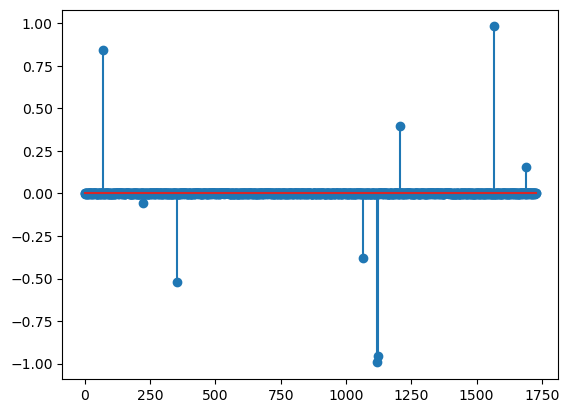

In [4]:
plt.stem(np.real(np.ravel(full_signal.signal_w)))

# 1. Querying GFast for datapoints to sample 

## Hyperparameters

GFast has three main hyperparameters: `b`, `num_subsample`, and `num_repeat`.
- `b`: the inner dimension of the subsampled matrices
- `num_subsample` ($C$): the number of subsampling matrices $M_c$ to make
- `num_repeat`: the number of times to repeat the subsampling

While we want to find `b` such that, theoretically, each $B_c = O(S)$, in practice we hyperparameter tune `b` to be the smallest value that recovers the signal. From here, we set `num_subsample` to be $n//b$, but this value can be fixed at any constant (with a max value of n//b). To run NR-GFAST, we ideally want `num_repeat` to be $n$ to satisfy theoretical guarentees. However, this can also be hyperparameter tuned to be the smallest value that recovers the signal. If you're running GFast instead, then `num_repeat` is locked to 1.

For this tutorial, we'll use `b = 2`, `num_subsample = 6//2 = 3`, and `num_repeat = 6`.

In [4]:
b = 2
num_subsample = n//b
num_repeat = n

`delays_method_source` should always be set to `identity` to create the partial identity subsampling matrices $M_c$. `delays_method_channel` is set to `nr` to run NR-GFast and `identity` to run GFast.

In [5]:
delays_method_source = 'identity'
delays_method_channel = 'nr'

## Creating the Helper Class
Now that we have defined all hyperparameters, we can create the helper class. This class will be used to generate the training and test data, and to run the experiment. All of our data will be stored in the `tutorial_results` folder.  This code is directly implemented in `get_qary_indices.py` from the `gfp_exp` folder. First, we need to generate all the query indices: these are the points in the signal where we need to sample the function. We can compute these values later in the next step.

In [6]:
base_dir = Path('')
newfolder = 'tutorial_results'
exp_dir = base_dir / newfolder
exp_dir.mkdir(parents=True, exist_ok=True)
query_args = {
    "query_method": 'generate_samples', # specify this for step 1
    "train_samples": 'simple', 
    "method": "generate_samples", # specify this for step 1
    "num_subsample": num_subsample,
    "num_repeat": num_repeat,
    "b": b,
    "folder": exp_dir,
    "delays_method_channel": delays_method_channel
}
signal_args = {
    "n":n,
    "q":q,
    "query_args":query_args,
    "len_seq":n,
    "banned_indices_toggle": True,
    "banned_indices": banned_indices,
    "delays_method_channel": delays_method_channel
    }
test_args = {
        "n_samples": 100,
        "method": "generate_samples" # specify this for step 1
    }
file_path = os.path.join(exp_dir, 'train', 'samples')
if not os.path.exists(file_path):
    os.makedirs(file_path, exist_ok=True)
file_path = os.path.join(exp_dir, 'test')
if not os.path.exists(file_path):
    os.makedirs(file_path, exist_ok=True)

try:
    helper = Helper(signal_args=signal_args,
                    methods=["gfast"],
                    subsampling_args=query_args,
                    test_args=test_args,
                    exp_dir=exp_dir)
except SystemExit:
    print("exited")

exited


Let's examine the folder structure:

`train`: contains the training data GFast will use to sample

`train/samples`: folder location for the query indices
- `M{i}_D{j}_qaryindices.pickle`: pickle file containing the query indices to sample from the $i^{\text{th}}$ subsampling matrix and $j^{\text{th}}$ repeat. These indices are encoded into their mixed-radix representation of the indices.
- `M{i}_D{j}_queryindices.pickle`: pickle file containing the query indices to sample from the $i^{\text{th}}$ subsampling matrix and $j^{\text{th}}$ repeat. Contains a `num_samples` x `n` numpy array of indices to sample from. This contains the exact information as `M{i}_D{j}_qaryindices.pickle`, but is more readable.

`train/transforms`: folder location for the subsampled Fourier transforms $U_c$

`test`: contains the random query indices GFast will use to test the recovered Fourier coefficients on
- `test/signal_t_query_qaryindices.pickle`: pickle file containing the random query indices to sample, encoded into their mixed-radix representation of the indices.
- `test/signal_t_queryindices.pickle`: pickle file containing the random query indices to sample, containing a `n` x `num_samples` numpy array of indices to sample from.

# 2. Computing the samples

Now that we know what indices to sample from, we can compute the samples. Here, since we created an example signal, and thus we know all $N$ time domain values that correspond to each query index, we can simply look up the value through `signal_t`. However, in practice, we can query these indices into a model or function to get the corresponding values.

For the training samples, we save them out as a `M{i}_D{j}.pickle` file, which is a 1D numpy array of the values that correspond to the query indices from `M{i}_D{j}_queryindices.pickle`. For the test samples, we save them out to the dictionary `signal_t.pickle`, where the keys are the query indices in mixed-radix format, and the values are the corresponding values.

In [7]:
#compute training samples
for i in range(num_subsample):
        for j in range(num_repeat):
            query_indices_file = os.path.join(exp_dir, "train", "samples", "M{}_D{}_queryindices.pickle".format(i, j))
            query_indices = load_data(query_indices_file)
            block_length = len(query_indices[0])
            samples = np.zeros((len(query_indices), block_length), dtype=complex)
            all_query_indices = np.concatenate(query_indices)
            all_query_indices = all_query_indices.astype(int)
            indices_tuple = tuple(all_query_indices.T)
            all_samples = signal_t[indices_tuple]
            for k in range(len(query_indices)):
                start = k * block_length
                end = (k + 1) * block_length
                samples[k] = all_samples[start:end]
            samples = samples.T
            save_data(samples, os.path.join(exp_dir, "train", "samples", "M{}_D{}.pickle".format(i, j)))
# compute test samples
query_indices_file = os.path.join(exp_dir, "test", "signal_t_queryindices.pickle")
query_indices = load_data(query_indices_file)
query_indices = query_indices.T
query_qaryindices_file = os.path.join(exp_dir, "test", "signal_t_query_qaryindices.pickle")
query_qaryindices = load_data(query_qaryindices_file)
sample_file = os.path.join(exp_dir, "test", "signal_t.pickle")
block_length = len(query_indices[0])
samples = np.zeros(len(query_indices), dtype=complex)
samples_dict = {}
for k in range(len(query_indices)):
    index_vector = np.array(query_indices[k]).astype(int)
    indices = query_indices[k].astype(int)
    idx_tuple = tuple(indices.T)
    samples[k] = signal_t[idx_tuple]
samples_dict = dict(zip(query_qaryindices, samples))
save_data(samples_dict, sample_file)


## 3. Running GFast
Now that we have queried the model for the indices of the query points, we can compute the Fourier transform using GFAST. We will use the `Helper` class to compute the GFAST transform.

In [9]:
query_args = {
        "query_method": "simple", # Leave as simple 
        "num_subsample": num_subsample,
        "delays_method_source": delays_method_source, 
        "subsampling_method": "gfast", 
        "delays_method_channel": delays_method_channel,
        "num_repeat": num_repeat,
        "b": b,
        "t": n,
        "folder": exp_dir 
    }
signal_args = {
                "n":n,
                "q":q,
                "noise_sd":noise_sd,
                "query_args":query_args,
                "t": n,
                'banned_indices_toggle': True,
                'banned_indices': banned_indices
                }
helper = Helper(signal_args=signal_args, methods=["gfast"], subsampling_args=query_args, test_args=test_args, exp_dir=exp_dir)

100%|██████████| 18/18 [00:00<00:00, 12514.08it/s]


In [10]:
#compute the Fourier transform
model_kwargs = {}
model_kwargs["num_subsample"] = num_subsample
model_kwargs["num_repeat"] = num_repeat
model_kwargs["b"] = b
model_kwargs["noise_sd"] = noise_sd
model_result = helper.compute_model(method="gfast", model_kwargs=model_kwargs, report=True, verbosity=10)

Estimating GWHT coefficients with GFAST
Transform Time:0.0036957263946533203
cutoff =  0.08437500099999999
-----
iter  1
(0, 0) 0.0019827295308462796 3.5437500419999997
We have a Singleton at [0 0 1 2 2 1]
We have a Zeroton
(0, 2) 0.002879829022586127 3.5437500419999997
We have a Singleton at [0 2 0 0 1 2]
(0, 3) 0.0025368197273564217 3.5437500419999997
We have a Singleton at [0 3 0 2 0 3]
We have a Zeroton
We have a Zeroton
We have a Zeroton
We have a Zeroton
We have a Zeroton
(0, 9) 0.002849875740525658 3.5437500419999997
We have a Singleton at [2 1 2 1 2 0]
(0, 10) 60.89584177538002 3.5437500419999997
We have a Multiton
(0, 11) 0.0016894409078733064 3.5437500419999997
We have a Singleton at [2 3 0 1 2 0]
We have a Zeroton
We have a Zeroton
(0, 14) 0.0034525735961703752 3.5437500419999997
We have a Singleton at [3 2 1 1 1 2]
(0, 15) 0.002271670936087207 3.5437500419999997
We have a Singleton at [3 3 1 2 2 2]
We have a Zeroton
We have a Zeroton
We have a Zeroton
(1, 3) 0.0049561045895

## Testing against our held-out test set
Now that we have recovered the Fourier coefficients, we would like to see how accurate our reconstruction is. We can do this by computing the normalized mean squared error (NMSE) between the original signal and the reconstructed signal. This can be done either on the Fourier coefficients or the time-domain signal. Here we will a small subset of the entire time-domain signal and compare it to the original signal, which is a computationally efficient way to do this.

In [11]:
test_kwargs = {}
test_kwargs["beta"] = model_result.get("gwht")
nmse, r2 = helper.test_model("gfast", **test_kwargs)
print(f"NMSE: {nmse}")
print(f"R^2: {r2}")

NMSE: 0.00010924908371502428
R^2: 0.9998681706392409
